RBM包含两个层，可见层（visible layer）和隐藏层（hidden layer）。神经元之间的连接具有如下特点：层内无连接，层间全连接，显然RBM对应的图是一个二分图。一般来说，可见层单元用来描述观察数据的一个方面或一个特征，而隐藏层单元的意义一般来说并不明确，可以看作特征提取层。RBM和BM的不同之处在于，BM允许层内神经元之间有连接，而RBM则要求层内神经元之间没有连接，因此RBM的性质：当给定可见层神经元的状态时，各隐藏层神经元的激活条件独立；反之当给定隐藏层神经元的状态是，可见层神经元的激活也条件独立。

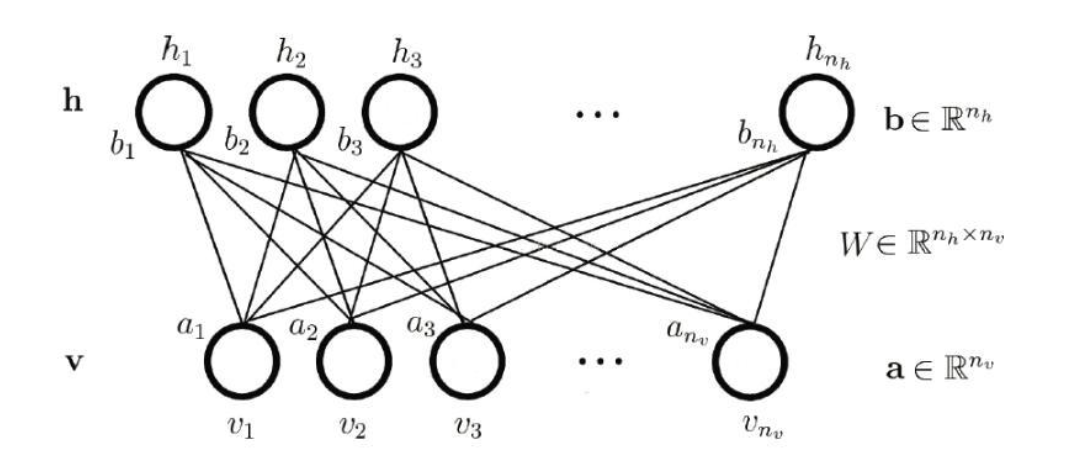

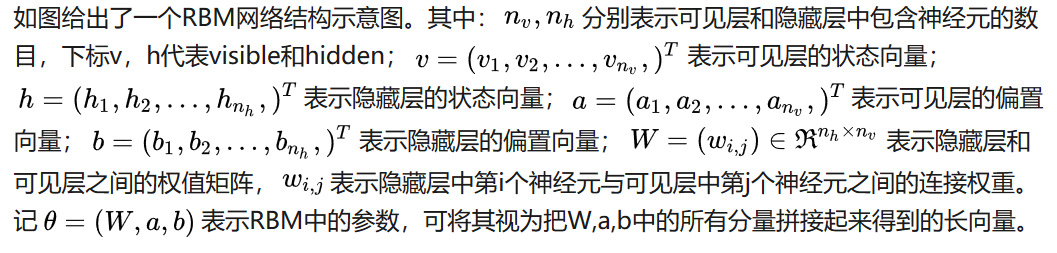

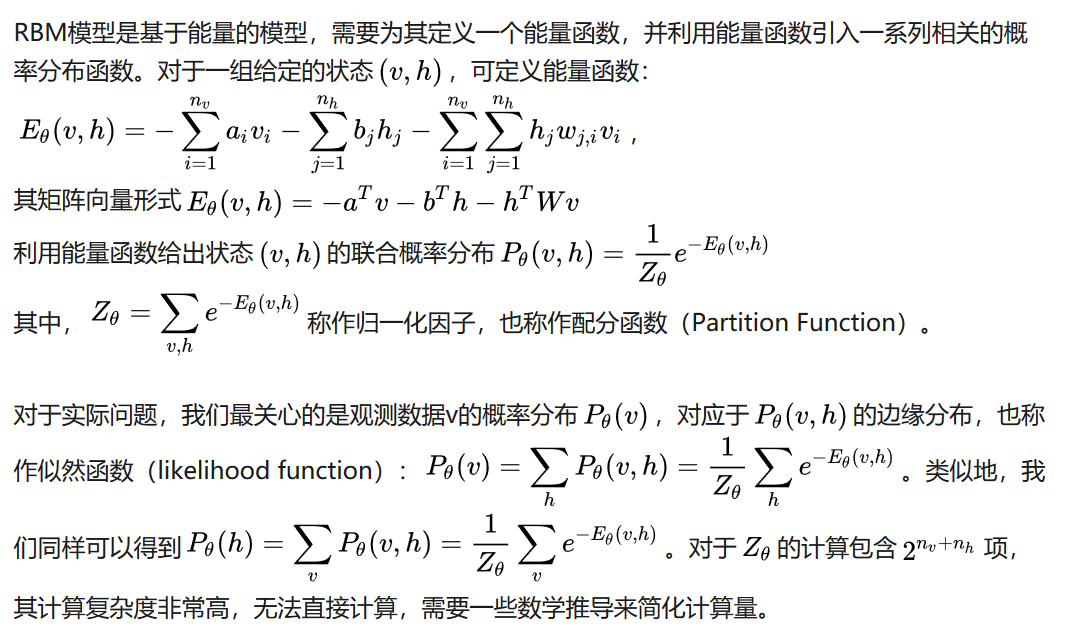

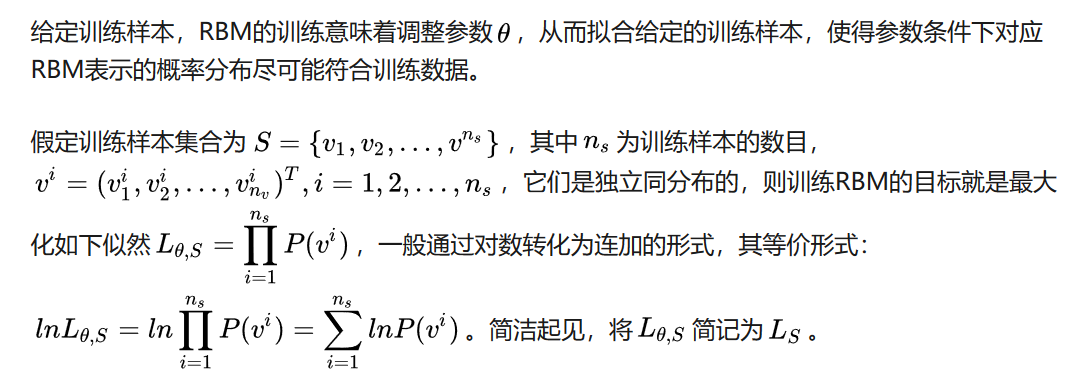

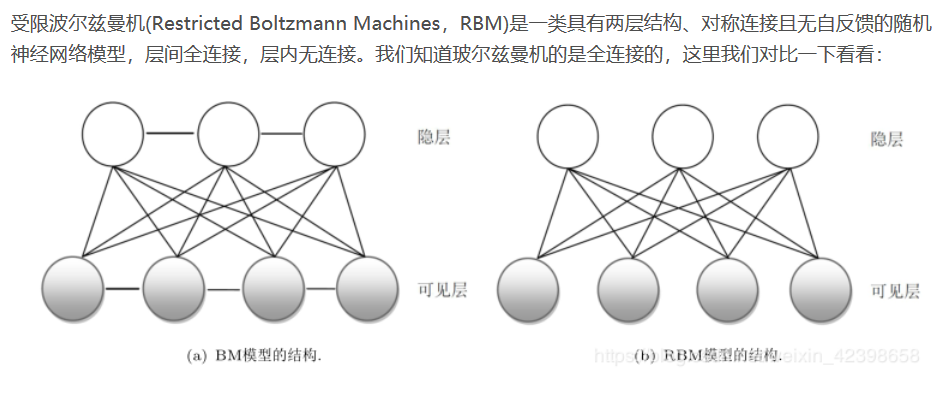

这里先简单的说一下区别，然后再次介绍一下二者的工作原理，然后详细深入介绍背景，二者最大的区别在输入层和隐层的连接方式上，BM模型是全连接的而RBM是相互独立的，他们的区别就在这里，那么为什么计算量会差别那么大呢？在概率中我们知道BM模型的输入和隐层的概率计算肯定是联合概率，因为他们各自有联系而RBM的概率虽然函数联合概率，但是因为独立，可以单独计算每个神经元的概率，然后相乘，进而达到计算量小的目的，另外就是RBM的学习算法是对比散度即CDCD算法，学习速度很快


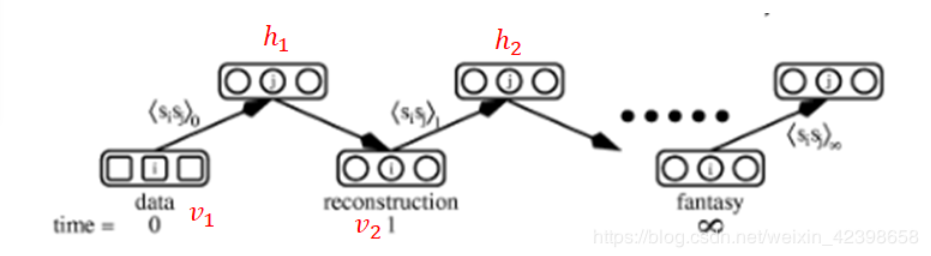

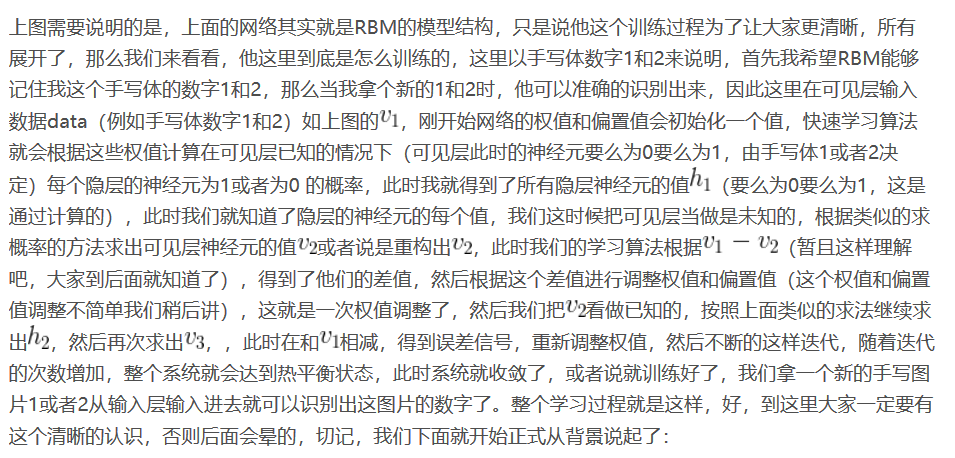

在诸多人工神经网络模型中，波尔兹曼机(Boltzmann Machine是Hinton和Sejnowski于1986年提出的一种根植于统计力学的随机神经网络。这种网络中的神经元是随机神经元，神经元的输出只有两种状态（未激活、激活）：一般用二进制的0和1表示，状态的取值根据概率统计法则决定。从功能上讲，BM是由随机神经元全连接组成的反馈神经网络，且对称连接，无自反馈：包含一个可见层和一个隐层的BM模型如图（a）所示。

BM具有强大的无监督学习能力，能够学习数据中复杂的规则。但是，拥有这种学习能力的代价是其训练（学习）时间非常长。此外，不仅无法确切地计算BM所表示的分布：甚至得到服从BM所表示分布的随机样本也很困难。为克服这一问题Smolensky[引入了一种限制的波尔兹曼机(Restricted Boltzman Machine , RBM)，RBM具有一个可见层，一个隐层，层内无连接，其结构如图1（b）所示。RBM具有很好的性质：在给定可见层单元状态〔输入数据）时，各隐单元的激活条件独立，反之，在给定隐单元状态时，可见层单元的激活亦条件独立。这样一来，尽管RBM所表示的分布仍无法有效计算，但通过Gibbs采样(Gibbssampling)可以得到服从RBM所表示分布的随机样本。此外：Roux和Bengio同从理论上证明，只要隐单元的数目足
够多，RBM能够拟合任意离散分布。

2006年，Hinton等人提出了一种深度信念网络(Deep BeliefNets,DBN)，并给出了该模型的一个高效学习算法。这个算法成为了其后至今深度学习算法的主要框架。在该算法中，一个DBN模型被视为由若干个RBM堆叠在一起：训练时可通过从低到高逐层训练这些RBM来实现：

       (1)   底部RBM以原始输入数据训练；

     （2）将底部RBM抽取的特征作为顶部RBM的输入训练；

     （3）过程（1）、（2）可以重复来训练所需要的尽可能多的层数。

由于RBM可以通过CD快速训练，这一框架绕过了直接从整体上训练DBN的高复杂度，从而将其化简为对多个RBM的
训练问题题。Hinton建议，经过这种方式训练后，可以再通过传统的学习算法〔如反向传播算法）对网络进行微调，从而使模型收敛到全局最优解。这种学习算法，本质上等同于先通过逐层RBM训练将模型的参数初始化为全局最优解范围附近，再通过传统学习算法进一步训练。这样一来，不仅解决了模型训练速度慢的问题，而且计算量也降低了。大量试验结果也表明，这种方式能够产生非常好的参数初始值，从而大大提升了模型的建模能力。自此，机器学习领域又产生了一个新的研究方向-----深度学习(Deep learning)，明确提出了面向人工智能的机器学习算法的设计目标。


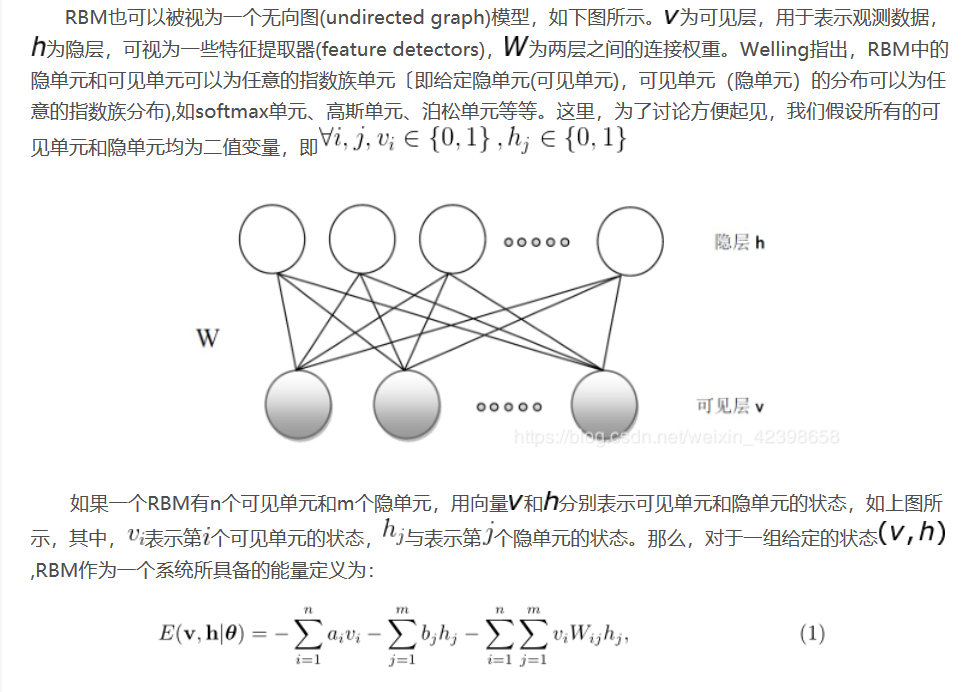

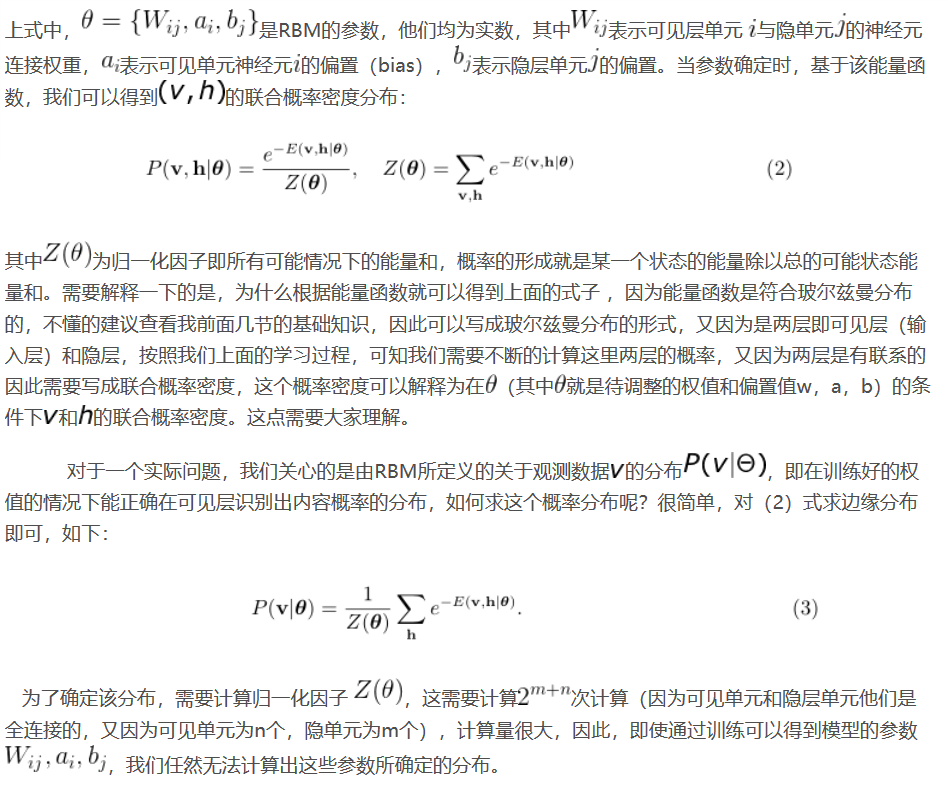

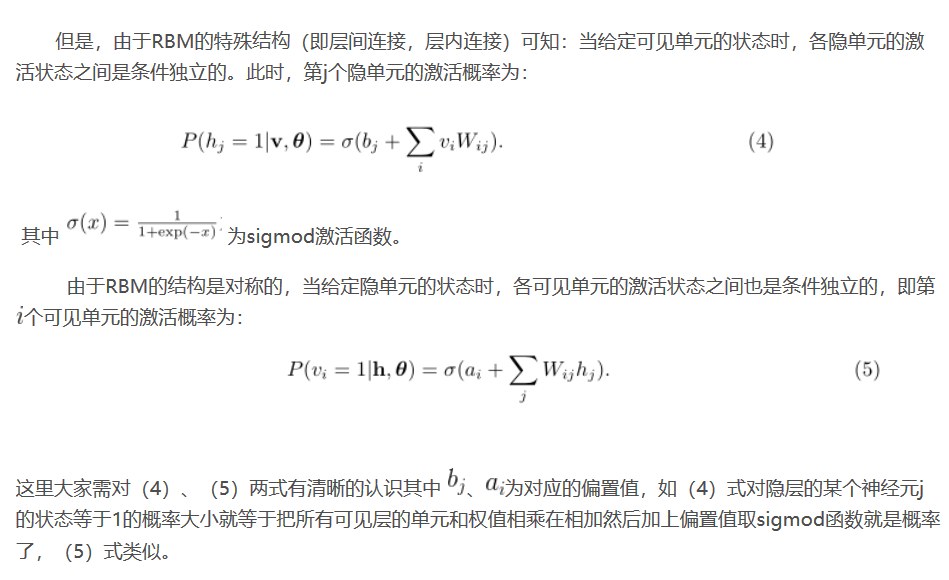

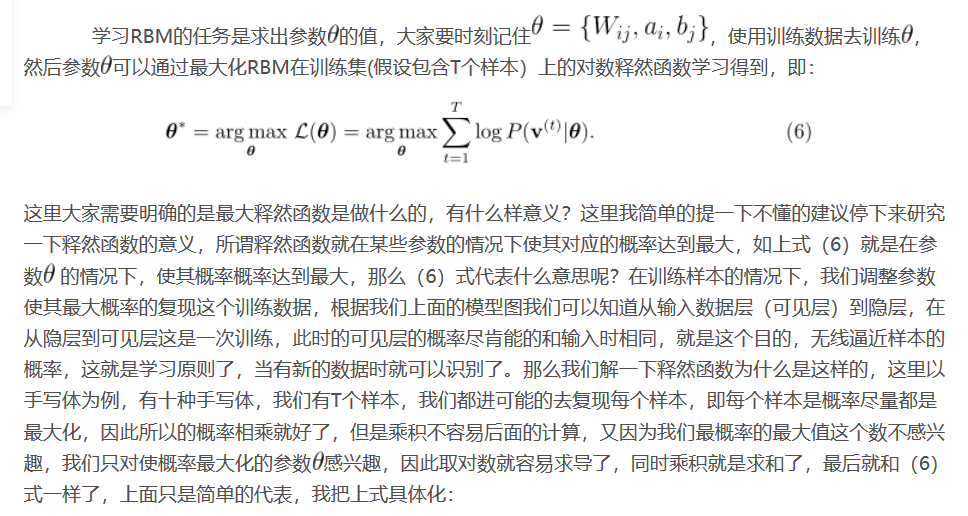

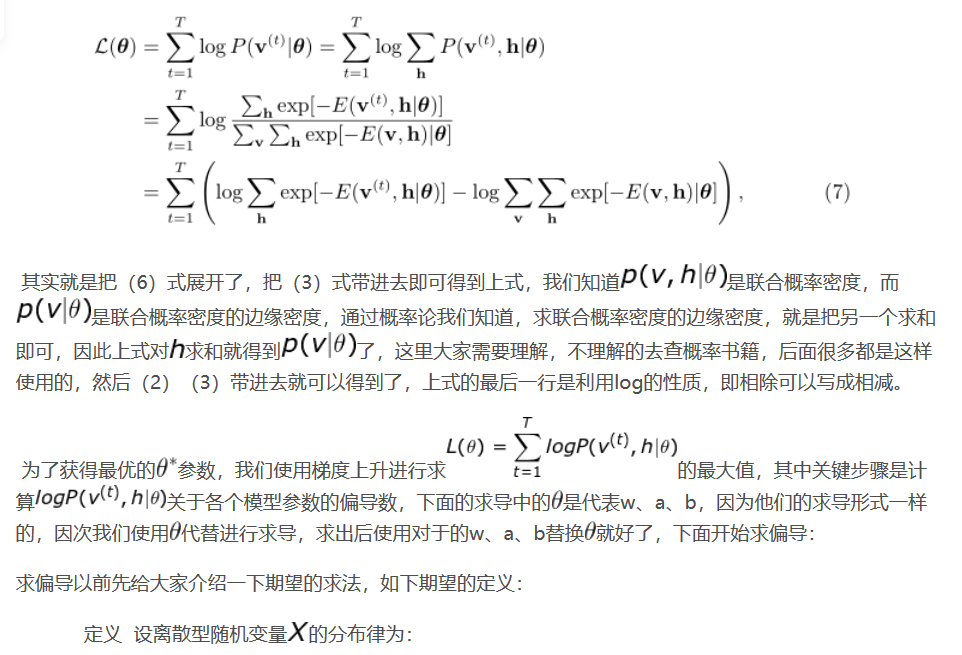

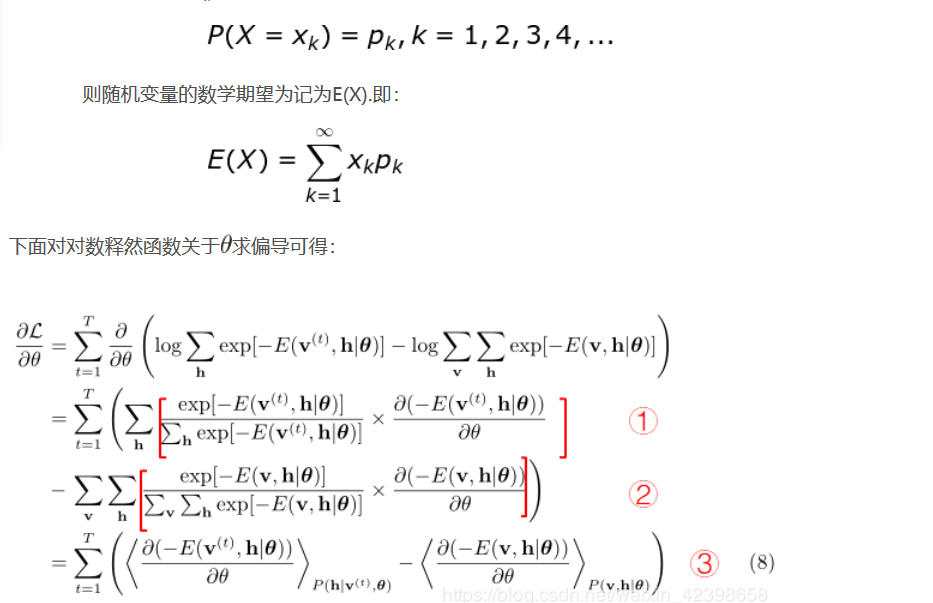

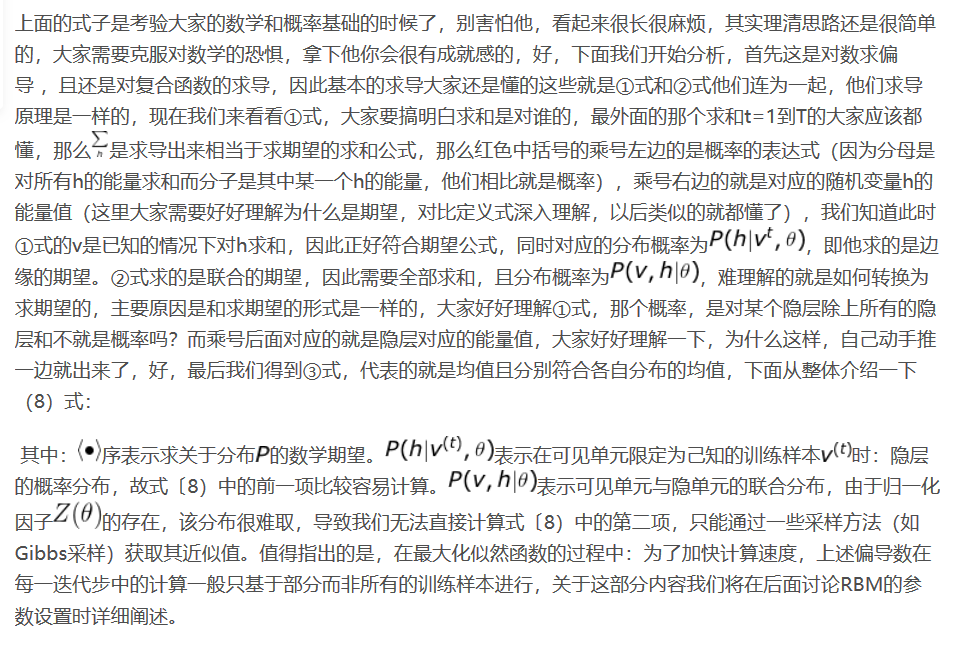

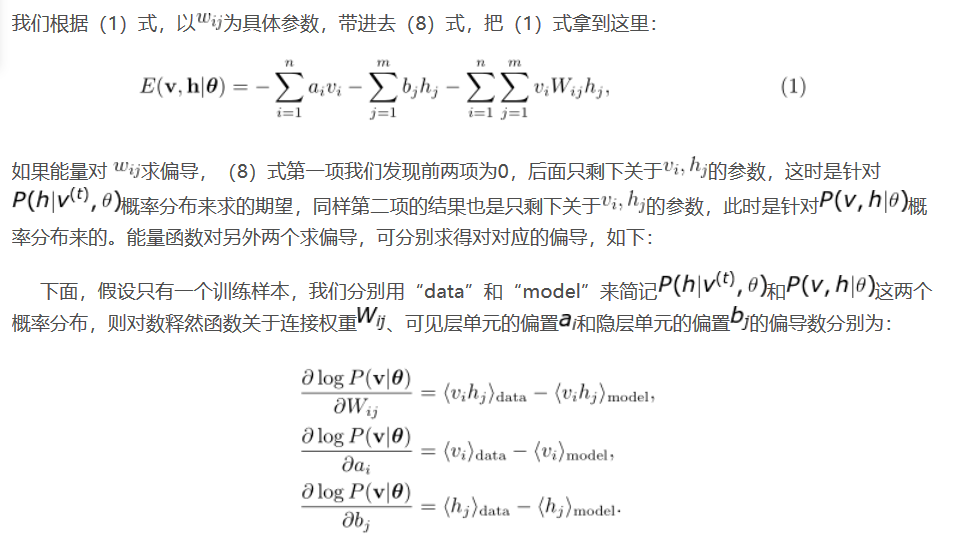

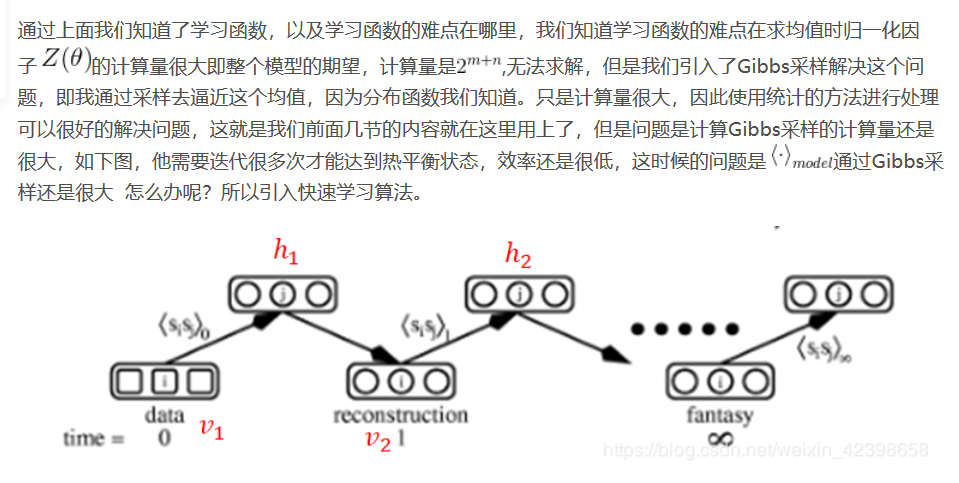

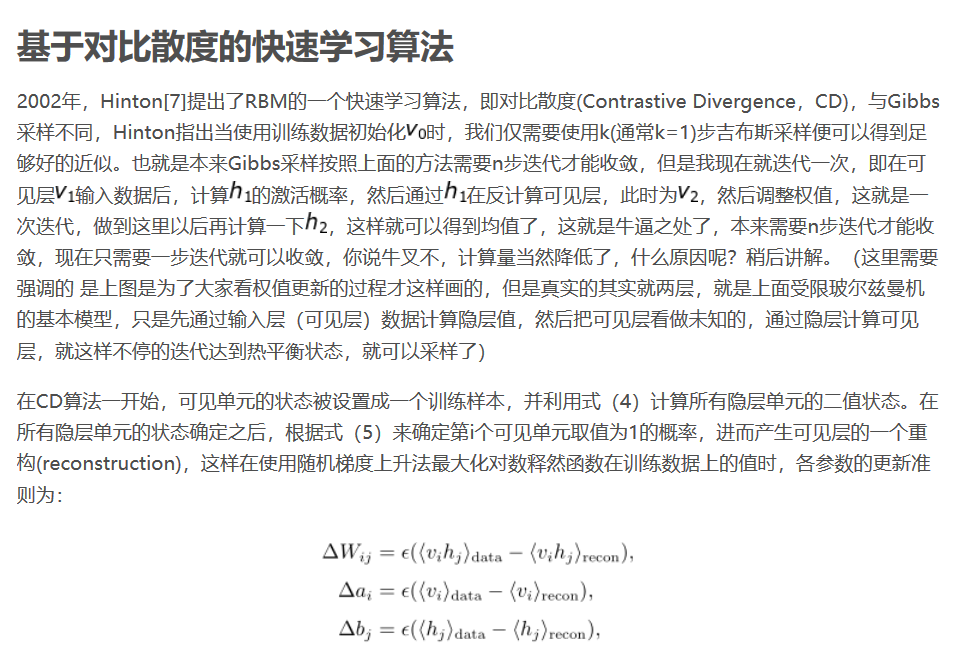

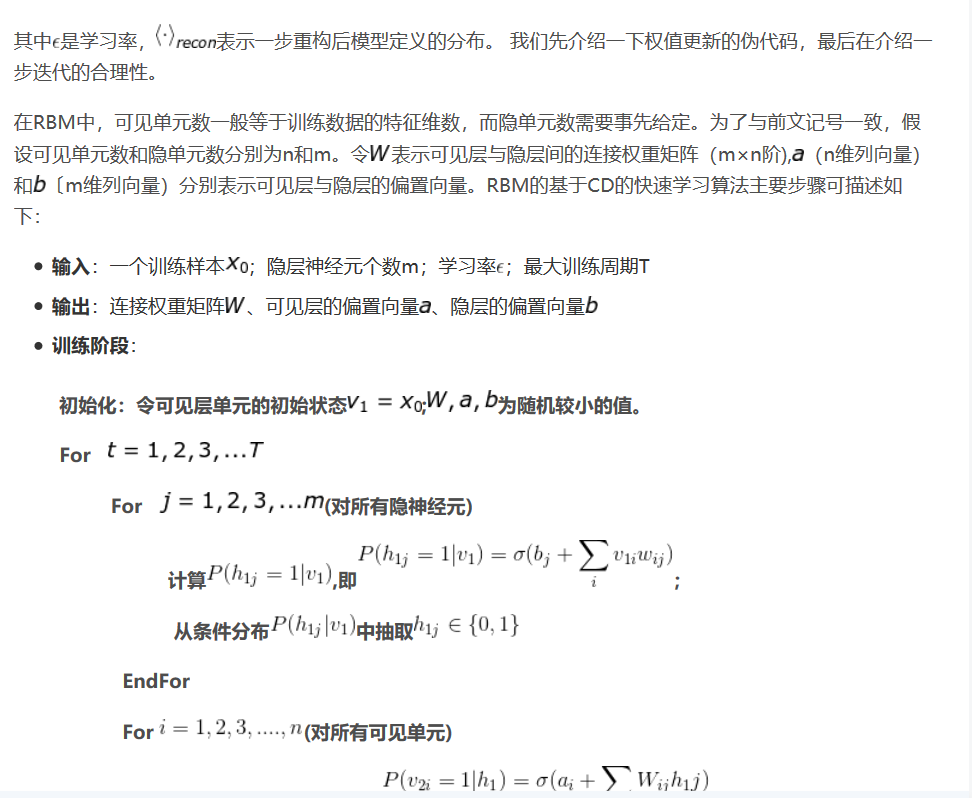

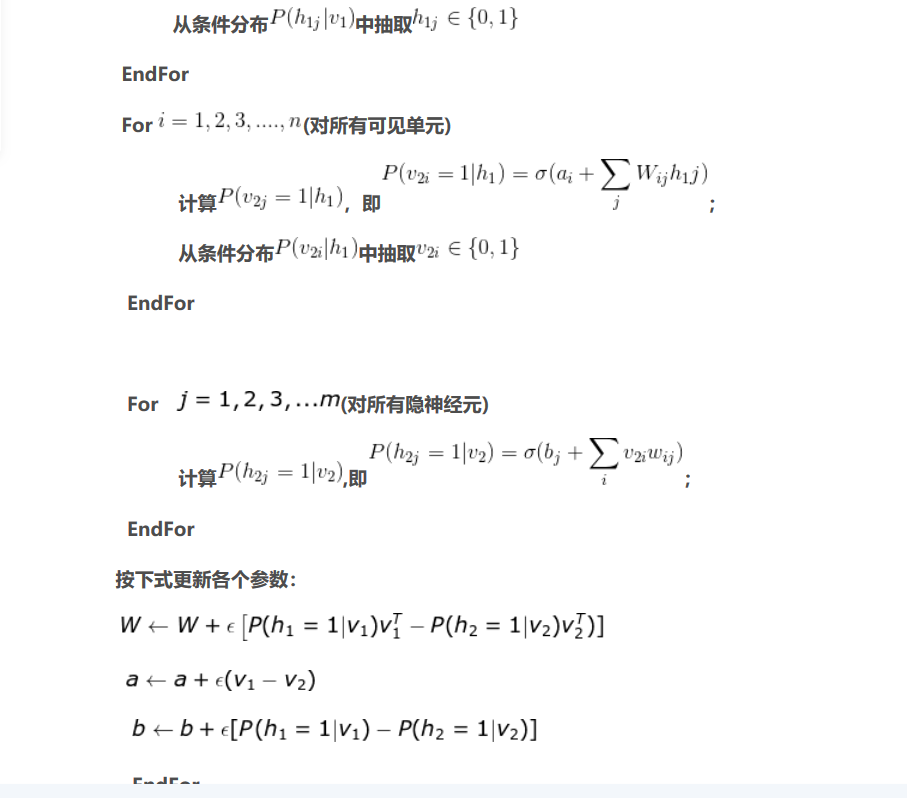

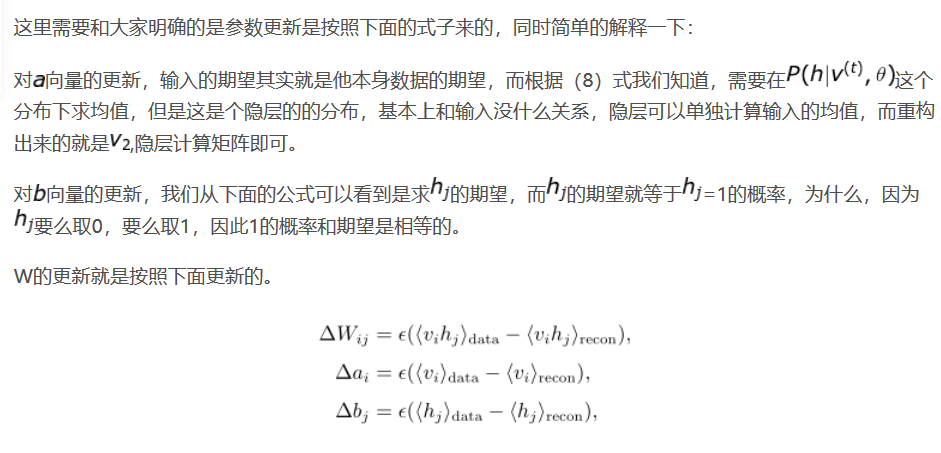

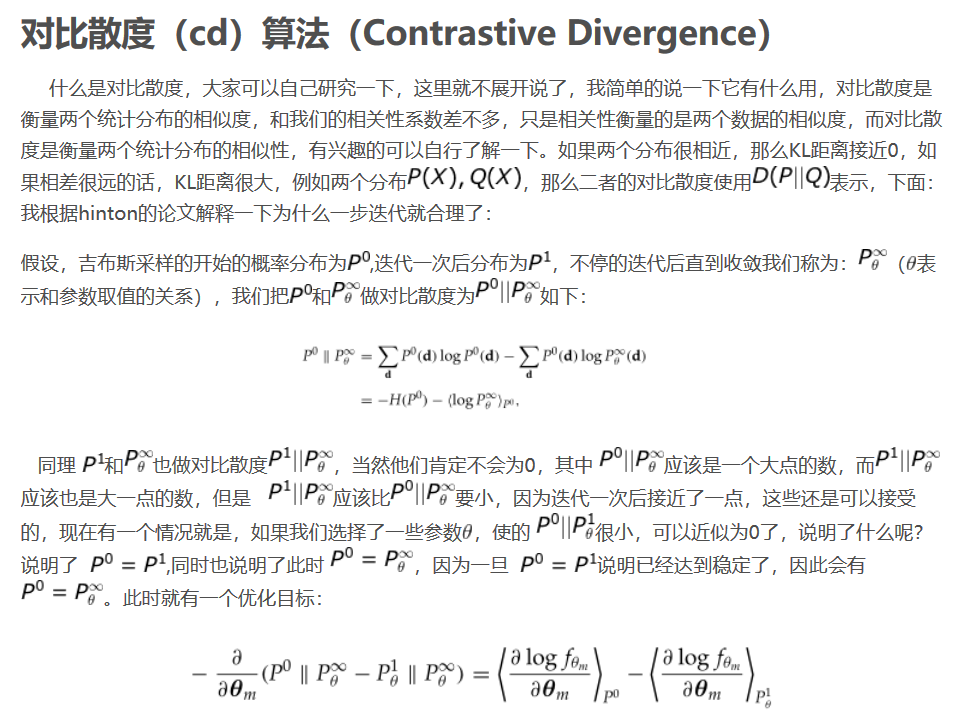

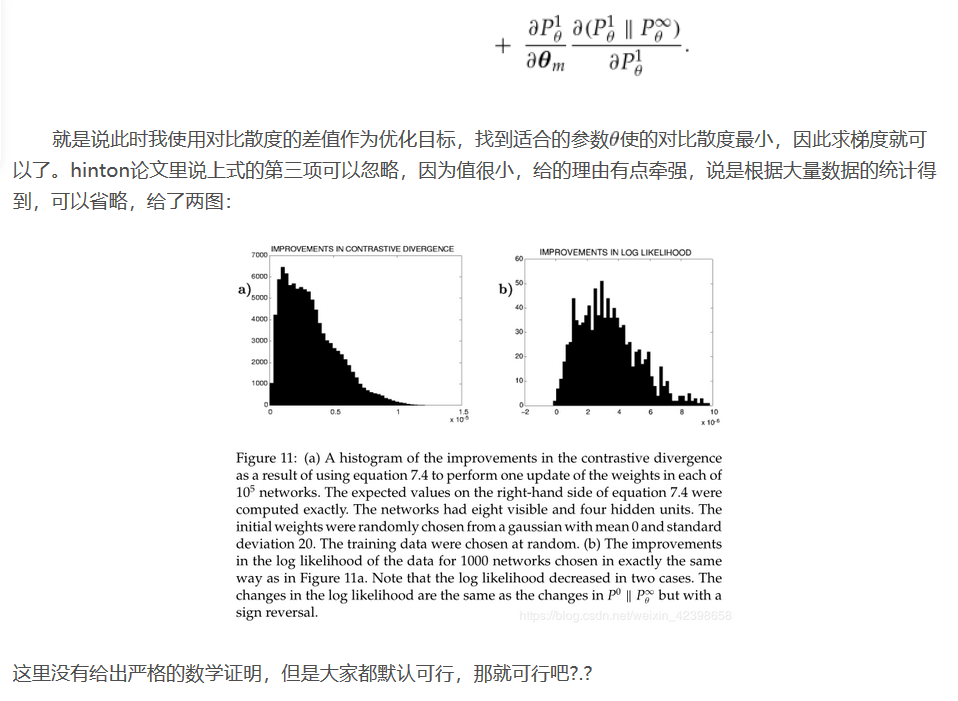

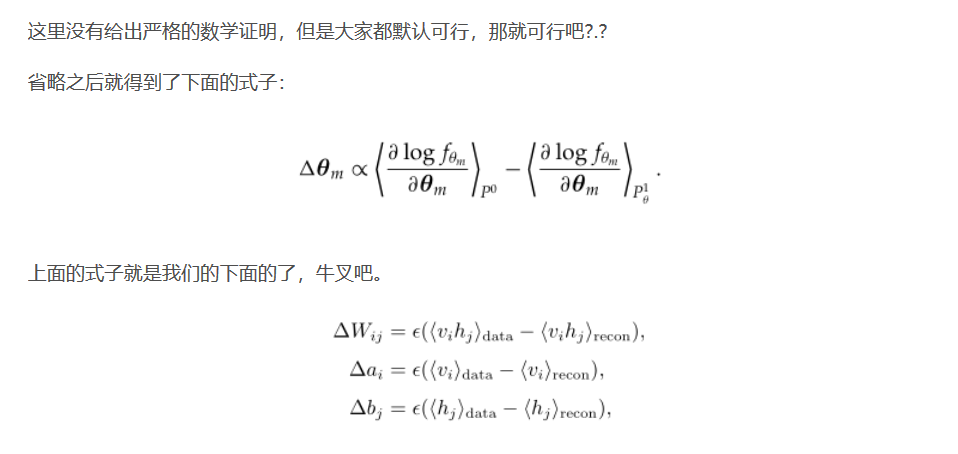

In [2]:
# -*- coding: utf-8 -*-
'''
受限的玻尔兹曼机:https://blog.csdn.net/zc02051126/article/details/9668439
'''
import matplotlib.pylab as plt
import numpy as np
import random


class RBM(object):
    '''
    定义一个RBM网络类
    '''
    
    def __init__(self,n_visible,n_hidden,momentum=0.5,learning_rate=0.1,max_epoch=50,batch_size=128,penalty=0,weight=None,v_bias=None,h_bias=None):
        '''
        RBM网络初始化
        
        使用动量的随机梯度下降法训练网络
        args:
            n_visible:可见层节点个数
            n_hidden：隐藏层节点个数
            momentum:动量参数 一般取值0.5,0.9,0.99  当取值0.9时，对应着最大速度1/(1-0.9)倍于梯度下降算法
            learning_rate：学习率
            max_epoch：最大训练轮数
            batch_size：小批量大小        
            penalty：规范化 权重衰减系数  一般设置为1e-4  默认不使用
            weight：权重初始化参数，默认是n_hidden x n_visible
            v_bias:可见层偏置初始化 默认是 [n_visible]
            h_bias:隐藏层偏置初始化 默认是 [n_hidden]
        '''
        #私有变量初始化
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.penalty = penalty        
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        
        if weight is None:
            self.weight = np.random.random((self.n_hidden,self.n_visible))*0.1        #用于生成一个0到0.1的随机符点数
        else:
            self.weight = weight
        if v_bias is None:
            self.v_bias = np.zeros(self.n_visible)                                    #可见层偏置
        else:
            self.v_bias = v_bias
        if h_bias is None:
            self.h_bias = np.zeros(self.n_hidden)                                     #隐藏层偏置
        else:
            self.h_bias = h_bias
                    
            
    def sigmoid(self,z):
        '''
        定义s型函数
        
        args:
            z：传入元素or list 、nparray
        '''
        return 1.0/(1.0+np.exp(-z))
    
    def forword(self,inpt):
        '''
        正向传播
        
        args:
            inpt : 输入数据(可见层) 大小为batch_size x n_visible
        '''
        z = np.dot(inpt,self.weight.T) + self.h_bias        #计算加权和
        return self.sigmoid(z)
    
    def backward(self,inpt):
        '''
        反向重构
        
        args:
            inpt : 输入数据(隐藏层) 大小为batch_size x n_hidden
        '''
        z = np.dot(inpt,self.weight) + self.v_bias    #计算加权个
        return self.sigmoid(z) 
    
    def batch(self):
        '''
        把数据集打乱，按照batch_size分组
        '''
        #获取样本个数和特征个数
        m,n = self.input_x.shape               
        
        #生成打乱的随机数
        per = list(range(m))
        random.shuffle(per)
        
        per = [per[k:k+self.batch_size] for k in range(0,m,self.batch_size)]
        
        batch_data = []
        for group in per:
            batch_data.append(self.input_x[group])        
        return batch_data

    
    def fit(self,input_x):
        '''
        开始训练网络
        
        args:
            input_x:输入数据集
        '''        
        self.input_x = input_x                                
                
        Winc = np.zeros_like(self.weight)
        binc = np.zeros_like(self.v_bias)
        cinc = np.zeros_like(self.h_bias)
        
        #开始每一轮训练
        for epoch in range(self.max_epoch):
              
            batch_data = self.batch()
            num_batchs = len(batch_data)
            
            #存放平均误差
            err_sum = 0.0            
            
            #随着迭代次数增加 penalty减小
            self.penalty = (1 - 0.9*epoch/self.max_epoch)*self.penalty
            
            
            #训练每一批次数据集
            for v0 in  batch_data:                     
                '''
                RBM网络计算过程
                '''                
                #前向传播  计算h0
                h0 = self.forword(v0)                
                h0_states = np.zeros_like(h0)                        
                #从 0, 1 均匀分布中抽取的随机值，尽然进行比较判断是开启一个隐藏节点，还是关闭一个隐藏节点
                h0_states[h0 > np.random.random(h0.shape)] = 1                
                #print('h0',h0.shape)              
                
                #反向重构  计算v1
                v1 = self.backward(h0_states)
                v1_states = np.zeros_like(v1)
                v1_states[v1 > np.random.random(v1.shape)] = 1
                #print('v1',v1.shape)
                
                #前向传播 计算h1
                h1 = self.forword(v1_states)
                h1_states = np.zeros_like(h1)                                        
                h1_states[h1 > np.random.random(h1.shape)] = 1
                #print('h1',h1.shape)
                
                
                '''更新参数 权重和偏置  使用栋梁的随机梯度下降法'''
                #计算batch_size个样本的梯度估计值
                dW = np.dot(h0_states.T , v0) - np.dot(h1_states.T , v1)
                #沿着axis=0进行合并
                db = np.sum(v0 - v1,axis=0).T
                dc = np.sum(h0 - h1,axis=0).T
            
                #计算速度更新
                Winc = self.momentum  * Winc + self.learning_rate * (dW  - self.penalty * self.weight)/self.batch_size 
                binc = self.momentum  * binc + self.learning_rate * db / self.batch_size
                cinc = self.momentum  * cinc + self.learning_rate * dc / self.batch_size
                
                #对于最大化对数似然函数  使用梯度下降法是加号 最小化是减号  开始更新
                self.weight = self.weight + Winc
                self.v_bias = self.v_bias + binc
                self.h_bias = self.h_bias + cinc
       
            
                
                err_sum = err_sum + np.mean(np.sum((v0 - v1)**2,axis=1))                        
                
            #计算平均误差
            err_sum = err_sum /num_batchs              
            print('Epoch {0},err_sum {1}'.format(epoch, err_sum))
            
    def predict(self,input_x):   
        '''
        预测重构值
        
        args:
            input_x：输入数据
        '''
        #前向传播  计算h0
        h0 = self.forword(input_x)                
        h0_states = np.zeros_like(h0)                        
        #从 0, 1 均匀分布中抽取的随机值，尽然进行比较判断是开启一个隐藏节点，还是关闭一个隐藏节点
        h0_states[h0 > np.random.random(h0.shape)] = 1                        
        
        #反向重构  计算v1
        v1 = self.backward(h0_states)
        return v1
    
    
    def visualize(self, input_x):  
        '''
        传入 形状为m xn的数据 即m表示图片的个数  n表示图像的像素个数
        
        其中 m = row x row
        n = s x s
        
        args:        
            input_x:形状为 m x n的数据
        '''        
        #获取输入样本的个数和特征数
        m, n = input_x.shape   
                
        #获取每张图像的宽和高 默认宽=高
        s = int(np.sqrt(n))          
                        
        #把所有图片以 row x row排列
        row = int(np.ceil(np.sqrt(m)))  
        
        #其中多出来的row + 1是用于绘制边框的 
        data = np.zeros((row*s + row + 1, row * s + row + 1)) - 1.0
        
        #图像在x轴索引
        x = 0  
        #图像在y轴索引
        y = 0  
        #遍历每一张图像
        for i in range(m):                 
            z = input_x[i]                  
            z = np.reshape(z,(s,s))
            #填充第i张图像数据                
            data[x*s + x + 1 :(x+1)*s + x + 1 , y*s + y + 1 :(y+1)*s + y + 1] = z  
            x = x + 1  
            #换行
            if(x >= row):  
                x = 0  
                y = y + 1                           
        return data  


def read_data(path):  
    '''
    加载数据集  数据按行分割，每一行表示一个样本，每个特征使用空格分割
    
    args:
        path：数据文件路径
    '''
    data = []  
    for line in open(path, 'r'):  
        ele = line.split(' ')  
        tmp = []  
        for e in ele:  
            if e != '':  
                tmp.append(float(e.strip(' ')))  
        data.append(tmp)  
    return data  


if __name__ == '__main__':  
    #加载MNIST数据集 总共有5000张图像，每张图像有784个像素点   MNIST数据集可以从网上下载
    data = read_data('data.txt')  
    data = np.array(data)  
    print(data.shape)                  #(5000, 784)    
    
    #创建RBM网络
    rbm = RBM(784, 100,max_epoch = 50,learning_rate=0.05)  
    #开始训练
    rbm.fit(data)  


    #显示64张手写数字 
    images = data[0:64]
    print(images.shape)
    a = rbm.visualize(images)
    fig = plt.figure(1,figsize=(8,8))      
    plt.imshow(a,cmap=plt.cm.gray)  
    plt.title('original data')      
      
    #显示重构的图像
    rebuild_value = rbm.predict(images)
    b = rbm.visualize(rebuild_value)  
    fig = plt.figure(2,figsize=(8,8))      
    plt.imshow(b,cmap=plt.cm.gray)  
    plt.title('rebuild data')  
      
    
    #显示权重
    w_value = rbm.weight  
    c = rbm.visualize(w_value)  
    fig = plt.figure(3,figsize=(8,8))    
    plt.imshow(c,cmap=plt.cm.gray)  
    plt.title('weight value(w)')  
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data.txt'